# Please excuse the mess!

# I haven't properly started working on this notebook


### The general idea
The general idea is to be able to express failure parameters in terms of really inuitive concepts like 
- mean time to failure (or expected lifespan -- e.g., 50 years)
- min wind speed (where failure rates start to increase)
- max wind speed (where failure is basically guaranteed)

I would then generate the less-intuitive failure parameters based on these metrics.

### Things to revisit

To use or not to use the log link function...
- **Pros:** Conventional for GLM models of Poisson processes -- guarantees that failure rates aren't negative. 
- **Cons:** This step feels more complicated than it needs to be.
- **Alternative:** Specify non-negative hyperpriors (means I can't use a normal distribution)
    
Reasonable assumptions for equipment lifetime

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import utils
import links
import generators
import estimation


%load_ext autoreload
%autoreload 2


In [2]:
.00001*8760*10

0.8760000000000001

In [3]:
X = pd.read_csv('inputs/weather.csv', index_col='time')
X.head()

,Precip,Temp,Wind,DayPrecip,HotCalm,WindStorm
time,,,,,,
0,0.0,54.50,5.67,0.0,9.611993,0.0
1,0.0,53.46,3.85,0.0,13.885714,0.0
2,0.0,53.16,3.34,0.0,15.916168,0.0
3,0.0,52.57,3.62,0.0,14.522099,0.0
4,0.0,51.00,3.77,0.0,13.527851,0.0


In [4]:
for key in X.keys():
    print key, np.percentile(X[key],95), key, np.percentile(X[key],99.999)
idx = X['WindStorm'] > 10
print idx.sum()

Precip 0.005 Precip 0.2312
Temp 71.53 Temp 100.72
Wind 12.71 Wind 38.36
DayPrecip 0.16740500000000194 DayPrecip 1.1754000000000016
HotCalm 38.92753623188406 HotCalm 1492.46758499938
WindStorm 1.0070245000000002 WindStorm 19.909605011160007
47


235 641


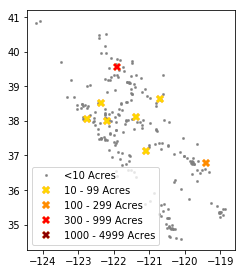

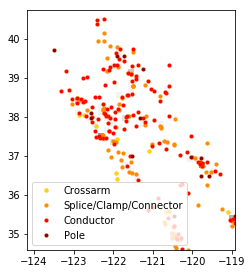

In [3]:

import matplotlib.colors as mcolors

df = pd.read_csv('raw_data/pge_fires.csv')

idx = pd.isnull(df.index)
for random in ['Balloons','Animal','Vehicle']:
    idx |= df['Contact']==random
idx |= df['Equipment'] != 'Conductor'
df = df[~idx]

idx = pd.isnull(df.index)
for fail in ['Crossarm','Splice/Clamp/Connector','Conductor','Pole']:
    idx |= df['Failure'] == fail
df = df[idx]

print len(df), len(idx)
fig, ax = plt.subplots(figsize=(0.7*(df['Longitude'].max()-df['Longitude'].min()), 
                                0.7*(df['Latitude'].max()-df['Latitude'].min())))
# H = ax.hist2d(df['Longitude'], df['Latitude'], bins=[np.arange(df['Longitude'].min(), df['Longitude'].max(), 0.15), np.arange(df['Latitude'].min(), df['Latitude'].max(), 0.15)], cmap='Greys', cmin=1, alpha=0.5)

idx = df['Size'].isin(['Structure Only','< 3 meters','.26 - 9.99 Acres','< 0.25 Acres','.26 - 9.99 Acres'])
ax.plot(df['Longitude'][idx], df['Latitude'][idx], ls=' ', marker='.', markersize=5, markeredgewidth=0.2, color='0.5', label='<10 Acres')



colors = ['Gold','darkorange','red','darkred']
for i, size in enumerate(['10 - 99 Acres','100 - 299 Acres','300 - 999 Acres','1000 - 4999 Acres']):
    idx = df['Size']==size
    ax.plot(df['Longitude'][idx], df['Latitude'][idx], ls=' ', marker='X', markersize=8, markeredgecolor='darkorange', markeredgewidth=0.2, color=colors[i], label=size)
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(0.7*(df['Longitude'].max()-df['Longitude'].min()), 
                                0.7*(df['Latitude'].max()-df['Latitude'].min())))
H = ax.hist2d(df['Longitude'], df['Latitude'], bins=[np.arange(df['Longitude'].min(), df['Longitude'].max(), 0.15), np.arange(df['Latitude'].min(), df['Latitude'].max(), 0.15)], cmap='Greys', cmin=1, alpha=0.5)

colors = ['Gold','darkorange','red','darkred']
for i, size in enumerate(['Crossarm','Splice/Clamp/Connector','Conductor','Pole']):
    idx = df['Failure']==size
    ax.plot(df['Longitude'][idx], df['Latitude'][idx], ls=' ', marker='.', markersize=8, markeredgecolor='darkorange', markeredgewidth=0.2, color=colors[i], label=size)
ax.legend()
plt.show()



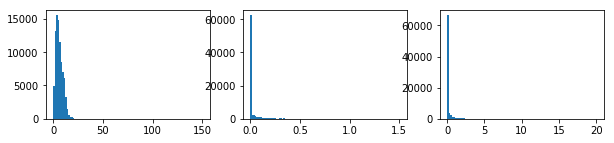

slope.DayPrecip         5.0
slope.Wind              0.2
threshold.DayPrecip     0.0
threshold.Wind         65.0
dtype: float64
link 0.01889096193703918
here 0.01889096193703918
slope.DayPrecip        10.0
slope.Wind              0.2
threshold.DayPrecip     0.0
threshold.Wind         65.0
dtype: float64
link 0.788181730830441
here 0.788181730830441
slope.DayPrecip        15.0
slope.Wind              0.2
threshold.DayPrecip     0.0
threshold.Wind         65.0
dtype: float64
link 0.9988092732407773
here 0.9988092732407773
slope.DayPrecip        20.0
slope.Wind              0.2
threshold.DayPrecip     0.0
threshold.Wind         65.0
dtype: float64
link 0.9999962808065184
here 0.9999962808065184


In [42]:
wind = np.linspace(0,150,100)
rain = np.linspace(0,1.5,100)
both = np.linspace(0,20,100)

bins = [wind,rain,both]

ww, rr = np.meshgrid(wind, rain)
xvals = pd.DataFrame(zip(ww.flatten(), rr.flatten()))

beta_w = [0.2,]
threshold_w = [65,]
beta_r = [5,10,15,20,]
threshold_r = [0,]

fig, ax = plt.subplots(ncols=3, figsize=(10,2))
for i, col in enumerate(['Wind','DayPrecip','WindStorm']):
    ax[i].hist(X[col].tolist(), bins=bins[i])
plt.show()


xx, yy = np.meshgrid(wind, rain)

cols = ['Wind','DayPrecip']
for betas in [(b_w, b_r) for b_w in beta_w for b_r in beta_r]:
    for thresholds in [(t_w, t_r) for t_w in threshold_w for t_r in threshold_r]:
#         _probs = 1./(1+np.exp(-1*(sum([betas[i]*(xvals[i]-(thresholds[i])) for i in xvals.keys()]))))
#         _probs = np.array(probs).reshape(ww.shape)

#         fig, ax = plt.subplots()
#         ax.contour(xx, yy, probs)#, bins=[wind,rain], weights=probs)
#         plt.show()
        
        _probs = 1./(1+np.exp(-1*(sum([betas[i]*(X[cols[i]]-(thresholds[i])) for i in xvals.keys()]))))
        params = pd.Series({'threshold.Wind': thresholds[0], 
                            'threshold.DayPrecip': thresholds[1], 
                            'slope.Wind': betas[0], 
                            'slope.DayPrecip': betas[1]})
        print params
        probs = links.Link().failure_prob(params, X)
        print 'link', probs.max()
        print 'here', _probs.max()
        
        


# for threshold in [15,20,25,30,40]:
#     tol = 1./(8760*100)
#     beta_1 = (1./(threshold+50))*np.log(1./tol-1)
#     lam = 1./(1+np.exp(-1*(beta_1*(wind-(threshold+50)))))

#     if threshold == 15:
#         fig, ax = plt.subplots()
#         ax.plot(wind, lam)
#         ax.set_title(threshold)
#         plt.show()
        
        
#     print threshold, '\t', beta_1


In [15]:
idx = X['DayPrecip'] >= X['DayPrecip'].sort_values(ascending=False).iloc[3*24]

precip = np.linspace(0,X['DayPrecip'].max(), 100)
wind = np.linspace(0,100, 100)

for threshold in [0.6,0.7,0.8, 0.9]:
    
    for windT in [15,20,25,30,40]:
        tol = 1./(8760*100)
        beta_2 = (1./threshold)*np.log(1./tol-1)
        lam = 1./(1+np.exp(-1*(1.*(precip-threshold)+0.2*(wind-(windT+50)))))
        beta_2 = 15

#         fig, ax = plt.subplots(ncols=3, figsize=(7,3))
#         ax[0].plot(precip, lam)
#         ax[0].set_title(threshold)
#         ax[1].plot(wind, lam)
#         ax[1].set_title(15)
#         ax[2].hist((1./1+np.exp(-1*(beta_2*(X['Day'])))))
#         plt.show()
        
        scenario = pd.Series(['constant', 0.2, 'constant', windT+50, 'constant', beta_2, 'constant', 0.6], 
                             index=['Wind.slope_distribution', 'Wind.slope_hyperparams', 
                                   'Wind.threshold_distribution', 'Wind.threshold_hyperparams',
                                   'DayPrecip.slope_distribution','DayPrecip.slope_hyperparams',
                                   'DayPrecip.threshold_distribution','DayPrecip.threshold_hyperparams'])
        params = generators.params(scenario, fleet_size=10000)
        p = links.Link().failure_prob(params.drop_duplicates(), X)
        print p.max()
        break

0.09380809044002497
0.09380809044002497
0.09380809044002497
0.09380809044002497


In [6]:
print X.head()



      Precip   Temp  Wind  DayPrecip    HotCalm  WindStorm
time                                                      
0        0.0  54.50  5.67        0.0   9.611993        0.0
1        0.0  53.46  3.85        0.0  13.885714        0.0
2        0.0  53.16  3.34        0.0  15.916168        0.0
3        0.0  52.57  3.62        0.0  14.522099        0.0
4        0.0  51.00  3.77        0.0  13.527851        0.0


99 3.663983519999964


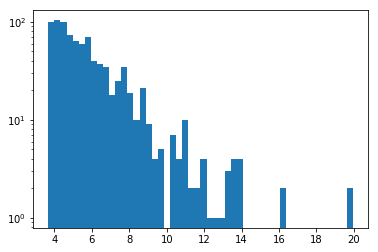

99.9 8.414246628000303


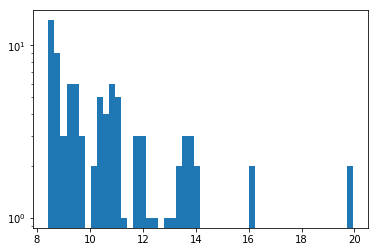

99.99 13.69618069939973


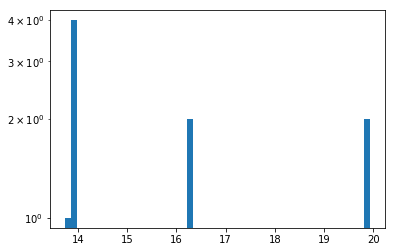

99.999 19.909605011160007


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


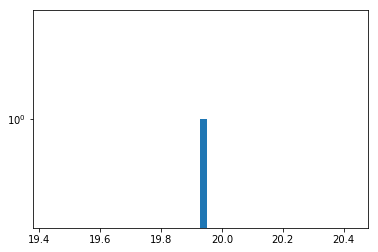

In [7]:
for t in [99,99.9, 99.99,99.999]:
    idx = X['WindStorm'] > np.percentile(X['WindStorm'], t)
    
    print t, np.percentile(X['WindStorm'], t)
    fig, ax = plt.subplots()
    ax.hist(X['WindStorm'].loc[idx].tolist(), bins=50, log=True)
    idx = X['WindStorm'].loc[idx].tolist()
    plt.show()

95 13.51
99 18.59
99.9 26.304010000000126
99.99 32.69265099998855
99.999 41.10184029999451


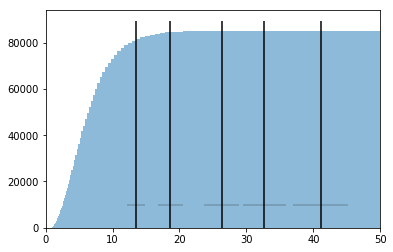

95 13.51
99 18.59
99.9 26.304010000000126
99.99 32.69265099998855
99.999 41.10184029999451


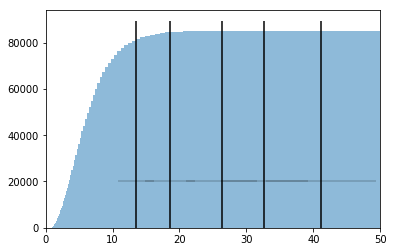

95 13.51
99 18.59
99.9 26.304010000000126
99.99 32.69265099998855
99.999 41.10184029999451


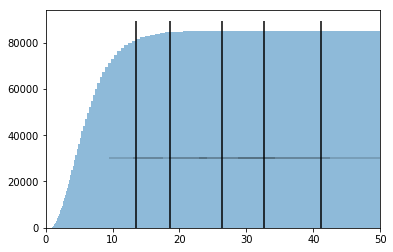

95 13.51
99 18.59
99.9 26.304010000000126
99.99 32.69265099998855
99.999 41.10184029999451


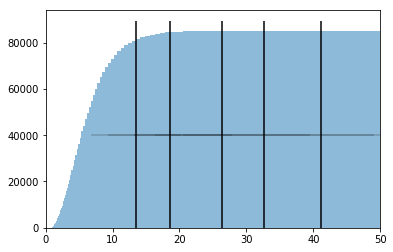

95 13.51
99 18.59
99.9 26.304010000000126
99.99 32.69265099998855
99.999 41.10184029999451


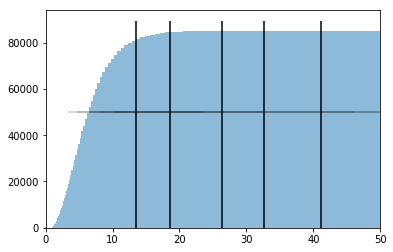

In [36]:
lims = [95,99,99.9,99.99,99.999]
covs = [0.1, 0.2, 0.3]
# colors = ['g','b','r']

for i, cov in enumerate(covs):
    fig, ax = plt.subplots()
    ax.hist(X['Wind'].tolist(), cumulative=True, bins=np.logspace(0,2,100), alpha=0.5)
    axlims = ax.get_ylim()
    for lim in lims:
        print lim, np.percentile(X['Wind'], lim)
        ax.vlines(np.percentile(X['Wind'], lim), *axlims, color='k')
        sig = cov * np.percentile(X['Wind'], lim)
        ax.hlines((i+1)*10000, np.percentile(X['Wind'], lim)-sig, np.percentile(X['Wind'], lim)+sig, alpha=0.2)
    # ax.set_xscale('log')
    ax.set_xlim(0,50)
    plt.show()

In [37]:
time_to_failure = 50 # years

In [38]:
lam = 1./(time_to_failure*8760)

In [39]:
lam

2.2831050228310503e-06

In [40]:
np.log(lam)

-12.989974189358582

In [47]:
wind_low = 20
wind_high = 100

time_low = 100
time_high = 1./8760

lam_low = 1./(time_low*8760)
lam_high = 1./(time_high*8760)

b = np.log(lam_low)
a = (1./(wind_high-wind_low))*(np.log(lam_high)-np.log(lam_low))

In [52]:
wind = np.linspace(0,110)
lam = np.exp(a*pd.Series(wind-wind_low).where(wind>wind_low,0)+b)

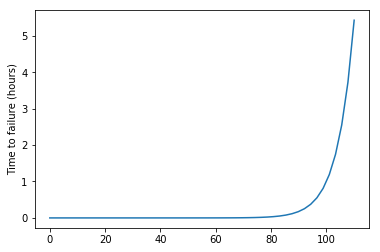

In [53]:
fig, ax = plt.subplots()
ax.plot(wind, lam)
ax.set_ylabel('Time to failure (hours)')
plt.show()

In [45]:
np.percentile(X['Wind'], 99), np.percentile(X['Wind'], 99.5), np.percentile(X['Wind'], 99.9)

(16.32, 18.32, 22.04)